We explore a few locality-preserving dimensionality reduction methods:  
- Locality Preserving Projections (LPP) [1, 2]
- Orthogonal Locality Preserving Projections (OLPP) [3]
- Neighborhood preserving projection (NPP), also known as neighborhood preserving embedding [3, 4]
- Orthogonal Neighborhood Preserving Projections (ONPP) [3]

These methods learn locality (neighborhood) preserving linear projections that are defined everywhere, i.e. they can be applied to new test data points, unlike methods like locally linear embedding (LLE), Laplacian eigenmaps, and IsoMap (which are defined only on the data points used to learn the embedding). They are different from global linear methods like PCA, whose goal is to find the projections directions along which the variance of the data is maximized.

#### References
1. He, Xiaofei, and Partha Niyogi. "Locality preserving projections." Advances in neural information processing
systems. 2004.
2. He, Xiaofei, et al. "Face recognition using LaplacianFaces." IEEE Transactions on Pattern Analysis & Machine
Intelligence 3 (2005): 328-340.
3. Kokiopoulou, Effrosyni, and Yousef Saad. "Orthogonal neighborhood preserving projections: A projection-based
dimensionality reduction technique." IEEE Transactions on Pattern Analysis and Machine Intelligence
29.12 (2007): 2143-2156.
4. He, Xiaofei, et al. "Neighborhood preserving embedding." Tenth IEEE International Conference on Computer 
Vision (ICCV'05) Volume 1. Vol. 2. IEEE, 2005.

In [1]:
import numpy as np
from multiprocessing import cpu_count
from dimension_reduction_methods import (
    LocalityPreservingProjection, 
    NeighborhoodPreservingProjection, 
    pca_wrapper, 
    wrapper_data_projection
)
from localized_pvalue_estimation import averaged_KLPE_anomaly_detection
from knn_classifier import wrapper_knn
from sklearn.model_selection import StratifiedShuffleSplit
from utils import wrapper_data_generate
from sklearn import datasets
from sklearn.utils import check_random_state
from collections import defaultdict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

%matplotlib inline

In [2]:
# Define some constants
methods_list = ['LPP', 'OLPP', 'NPP', 'ONPP', 'PCA']
n_jobs = max(cpu_count() - 2, 1)
seed_rng = np.random.randint(1, high=10000)
metric_primary = 'cosine'
shared_nearest_neighbors = False
# Choices are {'simple', 'SNN', 'heat_kernel'}
edge_weights = 'heat_kernel'

# Preprocessing with PCA as a first step of dimension reduction
pca_cutoff = 0.99

# Neighborhood size is chosen as a function of the number of data points. 
# In [1], it is recommended to chose `k = n^{2 / 5} = n^0.4`
neighborhood_constant = 0.4

COLORS = ['r', 'b', 'g', 'y', 'orange', 'm', 'lawngreen', 'gold', 'c', 'hotpink']

In [3]:
# Generate synthetic data according to a mixture of factor analysis (MFA) model
np.random.seed(seed_rng)

# number of mixture components
n_components = 10
# dimension of the observed space
dim = 100
# Specify a range for the latent dimension
dim_latent_range = (10, 20)

# Number of training points, test points, and proportion of anomalies in the test data
N = 1000
N_test = 1000
prop_anomaly = 0.1

data, data_test, labels_test = wrapper_data_generate(dim, dim_latent_range, n_components, 
                                                     N, N_test, prop_anomaly=prop_anomaly, 
                                                     anom_type='gaussian', seed_rng=seed_rng)
data_proj = dict()
data_test_proj = dict()

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 100
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 100
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 100
INFO:dimension_reduction_methods:Dimension of the projected subspace = 3
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


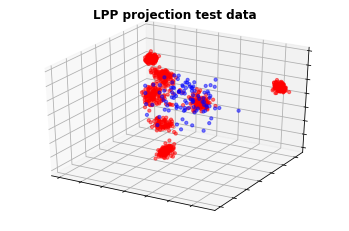

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 100
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 100
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 100
INFO:dimension_reduction_methods:Dimension of the projected subspace = 3
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


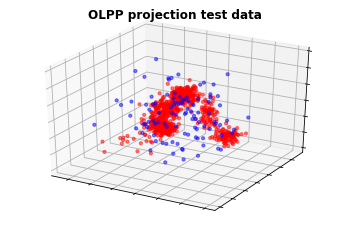

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 100
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 100
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 100
INFO:dimension_reduction_methods:Dimension of the projected subspace = 3
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


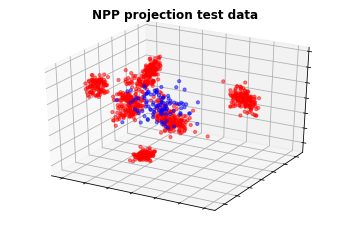

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 100
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 100
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 100
INFO:dimension_reduction_methods:Dimension of the projected subspace = 3
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


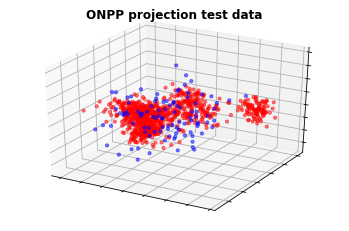

INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 100
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 100
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3


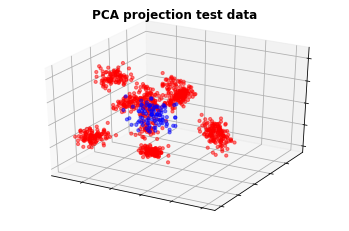

In [4]:
c = [COLORS[v] for v in labels_test]
for method in methods_list:
    _, data_proj = wrapper_data_projection(data, method, data_test=data_test, metric='cosine', 
                                           snn=True, ann=True, dim_proj=3, seed_rng=seed_rng)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data_proj[:, 0], data_proj[:, 1], data_proj[:, 2], marker='o', c=c, s=10, alpha=0.5)
    ax.set_title('{} projection test data'.format(method), fontweight='bold')
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.zaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    plt.show()

In [5]:
def project_synthetic_data(data, colors, name_str):
    # Plot the original data in 3d
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=colors, cmap=plt.cm.rainbow)
    ax.set_title('{} data'.format(name_str), fontweight='bold')
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.zaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    plt.show()
    
    # Project the data to 2d using different methods and plot
    for method in methods_list:
        data_proj, _ = wrapper_data_projection(data, method, metric='euclidean', snn=False, ann=True, dim_proj=2)
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(data_proj[:, 0], data_proj[:, 1], c=colors, cmap=plt.cm.rainbow)
        ax.set_title('{} projection of {} data'.format(method, name_str), fontweight='bold')
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')
        plt.show()


### Projection of S-curve data

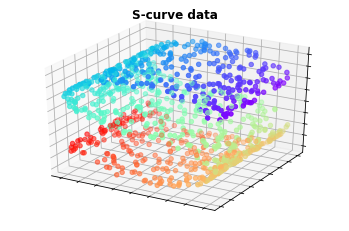

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3
INFO:dimension_reduction_methods:Dimension of the projected subspace = 2
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


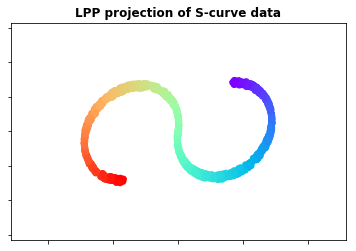

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3
INFO:dimension_reduction_methods:Dimension of the projected subspace = 2
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


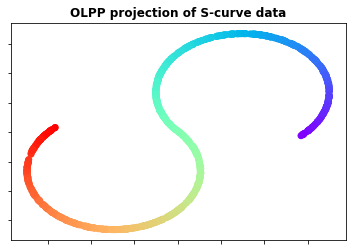

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3
INFO:dimension_reduction_methods:Dimension of the projected subspace = 2
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


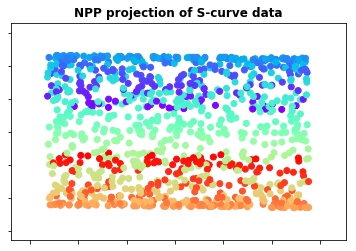

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3
INFO:dimension_reduction_methods:Dimension of the projected subspace = 2
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


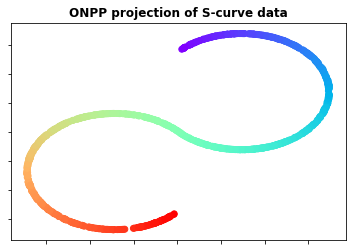

INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 2


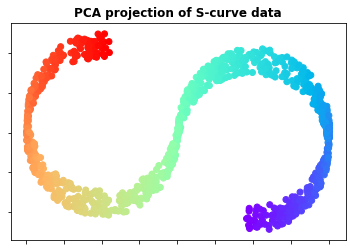

In [6]:
data, colors = datasets.make_s_curve(n_samples=N, random_state=seed_rng)
project_synthetic_data(data, colors, 'S-curve')

### Projection of Swiss roll data

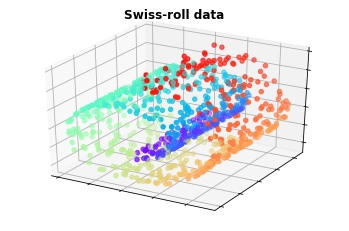

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3
INFO:dimension_reduction_methods:Dimension of the projected subspace = 2
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


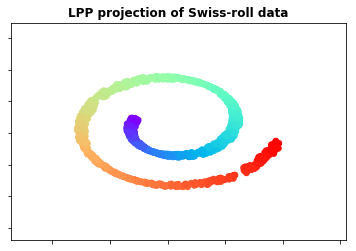

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3
INFO:dimension_reduction_methods:Dimension of the projected subspace = 2
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


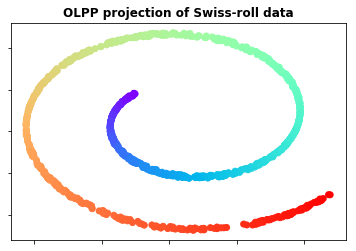

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3
INFO:dimension_reduction_methods:Dimension of the projected subspace = 2
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


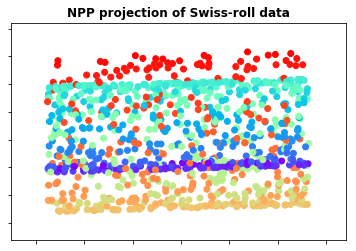

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3
INFO:dimension_reduction_methods:Dimension of the projected subspace = 2
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


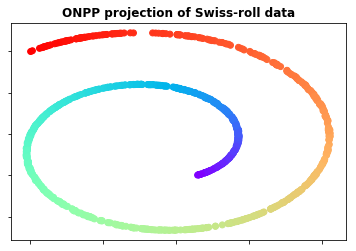

INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 2


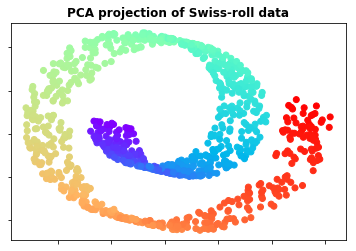

In [7]:
data, colors = datasets.make_swiss_roll(n_samples=N, random_state=seed_rng)
project_synthetic_data(data, colors, 'Swiss-roll')

### Severed sphere data

In [8]:
def generate_severed_sphere(n_samples=1000):
    # Create our sphere.
    random_state = check_random_state(0)
    p = random_state.rand(n_samples) * (2 * np.pi - 0.55)
    t = random_state.rand(n_samples) * np.pi

    # Sever the poles from the sphere.
    indices = ((t < (np.pi - (np.pi / 8))) & (t > ((np.pi / 8))))
    colors = p[indices]
    x, y, z = np.sin(t[indices]) * np.cos(p[indices]), np.sin(t[indices]) * np.sin(p[indices]), np.cos(t[indices])

    data = np.array([x, y, z]).T
    return data, colors

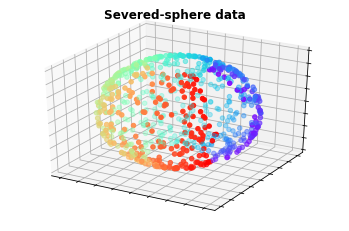

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3
INFO:dimension_reduction_methods:Dimension of the projected subspace = 2
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


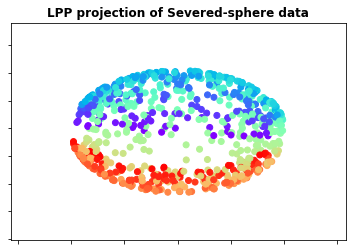

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3
INFO:dimension_reduction_methods:Dimension of the projected subspace = 2
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


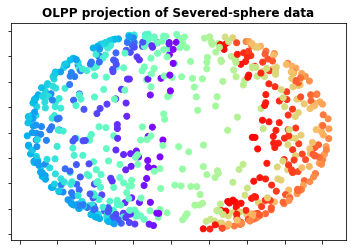

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3
INFO:dimension_reduction_methods:Dimension of the projected subspace = 2
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


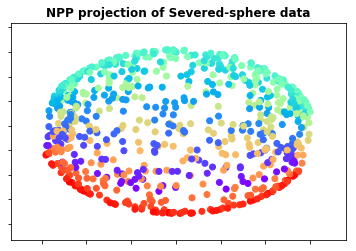

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3
INFO:dimension_reduction_methods:Dimension of the projected subspace = 2
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


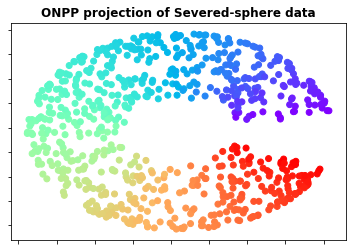

INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 3
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 2


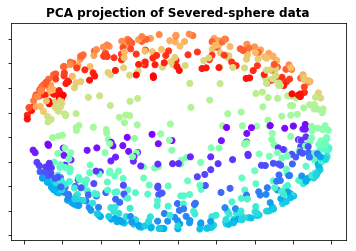

In [9]:
data, colors = generate_severed_sphere(n_samples=N)
project_synthetic_data(data, colors, 'Severed-sphere')

## MNIST data

In [10]:
from sklearn.datasets import fetch_openml

data_all, labels_all = fetch_openml('mnist_784', version=1, return_X_y=True)

# Scale the feature values to the range [0, 1]
data_all = data_all / 255.

In [11]:
# Create a random, stratified train/test split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed_rng)
data = labels = None
data_test = labels_test = None
for index_tr, index_te in sss.split(data_all, labels_all):
    data = data_all[index_tr, :]
    labels = labels_all[index_tr]
    data_test = data_all[index_te, :]
    labels_test = labels_all[index_te]

N, d = data.shape
N_te = labels_test.shape[0]
label_set, label_counts = np.unique(labels, return_counts=True)
_, label_counts_test = np.unique(labels_test, return_counts=True)

print("Number of features = {:d}. Number of classes = {:d}.".format(d, label_set.shape[0]))
print("\nNumber of training samples = {:d}.".format(N))
print("Number of samples per class in the training set:")
print(label_counts)

print("\nNumber of test samples = {:d}.".format(N_te))
print("Number of samples per class in the test set:")
print(label_counts_test)

Number of features = 784. Number of classes = 10.

Number of training samples = 35000.
Number of samples per class in the training set:
[3452 3939 3495 3571 3412 3156 3438 3646 3412 3479]

Number of test samples = 35000.
Number of samples per class in the test set:
[3451 3938 3495 3570 3412 3157 3438 3647 3413 3479]


INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 784
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 697
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 697
INFO:dimension_reduction_methods:Dimension of the projected subspace = 3
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


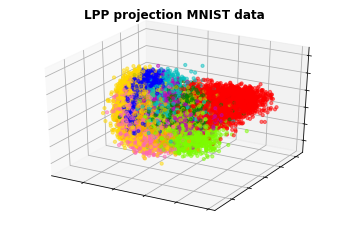

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 784
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 697
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 697
INFO:dimension_reduction_methods:Dimension of the projected subspace = 3
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


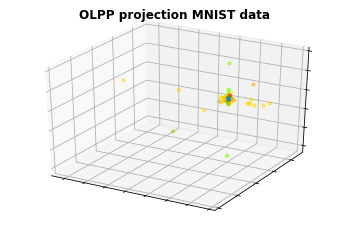

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 784
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 697
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 697
INFO:dimension_reduction_methods:Dimension of the projected subspace = 3
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


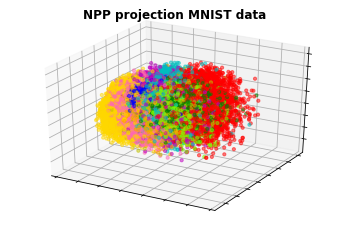

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 784
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 697
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 697
INFO:dimension_reduction_methods:Dimension of the projected subspace = 3
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


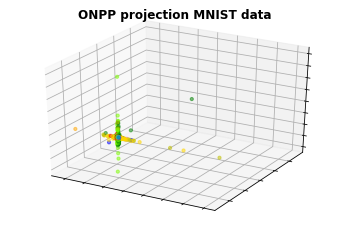

INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 784
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 697
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3


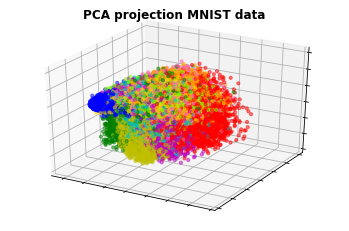

In [12]:
# Scatter plot of the 3D projection
label_map = {v: i for i, v in enumerate(label_set)}
c = [COLORS[label_map[v]] for v in labels]
for method in methods_list:
    data_proj, _ = wrapper_data_projection(data, method, metric='cosine', snn=False, ann=True, dim_proj=3, 
                                           seed_rng=seed_rng)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data_proj[:, 0], data_proj[:, 1], data_proj[:, 2], marker='o', c=c, s=10, alpha=0.5)
    ax.set_title('{} projection MNIST data'.format(method), fontweight='bold')
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.zaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    plt.show()

### Performance of a KNN classifier as a function of the projection dimension

In [13]:
metric = 'cosine'
snn = False
n_neighbors = 10
dim_proj_range = np.concatenate([np.array([10, 20, 30], dtype=np.int), 
                                 np.linspace(50, 300, num=7, dtype=np.int)])

error_rate_test = defaultdict(lambda: np.zeros(dim_proj_range.shape[0]))

In [14]:
# KNN classifier with all the features. 
# Applying PCA as pre-processing step to remove irrelevant features
data_proj, mean_data, transform_pca = pca_wrapper(data, cutoff=1.0, seed_rng=seed_rng)
data_test_proj = np.dot(data_test - mean_data, transform_pca)
error_rate_baseline = wrapper_knn(data_proj, labels, n_neighbors,
                                  data_test=data_test_proj, labels_test=labels_test,
                                  metric=metric, 
                                  shared_nearest_neighbors=snn,
                                  n_jobs=n_jobs,
                                  seed_rng=seed_rng)

INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 784
INFO:dimension_reduction_methods:Number of principal components accounting for 100.0 percent of the data variance = 697
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 697


In [15]:
for method in methods_list:
    print("KNN classifier with dimension reduction using {}".format(method))
    for j, dim_proj in enumerate(dim_proj_range):
        data_proj, data_test_proj = wrapper_data_projection(data, method, data_test=data_test, metric=metric, 
                                                            snn=snn, ann=True, dim_proj=dim_proj, 
                                                            pca_cutoff=pca_cutoff, seed_rng=seed_rng)
        # KNN classifier on the projected data
        error_rate_test[method][j] = wrapper_knn(data_proj, labels, n_neighbors,
                                                 data_test=data_test_proj, labels_test=labels_test,
                                                 metric=metric, 
                                                 shared_nearest_neighbors=snn,
                                                 n_jobs=n_jobs,
                                                 seed_rng=seed_rng)

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step


KNN classifier with dimension reduction using LPP


INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 784
INFO:dimension_reduction_methods:Number of principal components accounting for 99.0 percent of the data variance = 330
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 330
INFO:dimension_reduction_methods:Dimension of the projected subspace = 10
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.
INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 784
INFO:dimension_reduction_methods:Number of principal components accounting for 99.0 percent of the data variance = 330
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 330
INFO:dimension_reduction_methods:Dimension of the projected subspace = 20
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem

KNN classifier with dimension reduction using OLPP


INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 784
INFO:dimension_reduction_methods:Number of principal components accounting for 99.0 percent of the data variance = 330
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 330
INFO:dimension_reduction_methods:Dimension of the projected subspace = 10
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.
INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 784
INFO:dimension_reduction_methods:Number of principal components accounting for 99.0 percent of the data variance = 330
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 330
INFO:dimension_reduction_methods:Dimension of the projected subspace = 20
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem

KNN classifier with dimension reduction using NPP


INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 784
INFO:dimension_reduction_methods:Number of principal components accounting for 99.0 percent of the data variance = 330
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 330
INFO:dimension_reduction_methods:Dimension of the projected subspace = 10
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.
INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 784
INFO:dimension_reduction_methods:Number of principal components accounting for 99.0 percent of the data variance = 330
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 330
INFO:dimension_reduction_methods:Dimension of the projected subspace = 20
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem

KNN classifier with dimension reduction using ONPP


INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 784
INFO:dimension_reduction_methods:Number of principal components accounting for 99.0 percent of the data variance = 330
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 330
INFO:dimension_reduction_methods:Dimension of the projected subspace = 10
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.
INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 784
INFO:dimension_reduction_methods:Number of principal components accounting for 99.0 percent of the data variance = 330
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 330
INFO:dimension_reduction_methods:Dimension of the projected subspace = 20
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem

KNN classifier with dimension reduction using PCA


INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 784
INFO:dimension_reduction_methods:Number of principal components accounting for 99.0 percent of the data variance = 330
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 10
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 784
INFO:dimension_reduction_methods:Number of principal components accounting for 99.0 percent of the data variance = 330
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 20
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 784
INFO:dimension_reduction_methods:Number of principal components accounting for 99.0 percent of the data variance = 330
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 30
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 784
INFO:dimension_reduction_methods:Number of prin

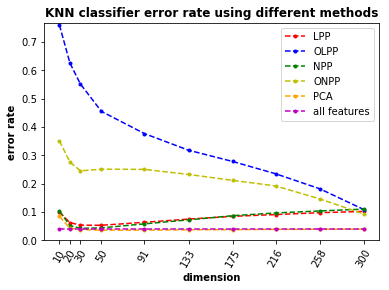

In [16]:
# Error rate of different methods as a function of projected dimension
fig = plt.figure()
y_min = error_rate_baseline
y_max = error_rate_baseline
j = 0
for method in methods_list: 
    plt.plot(dim_proj_range, error_rate_test[method], linestyle='--', color=COLORS[j], 
             marker='.', label=method)
    j += 1
    a = min(error_rate_test[method])
    b = max(error_rate_test[method])
    if a < y_min:
        y_min = a
        
    if b > y_max:
        y_max = b

# Baseline using all features
plt.plot(dim_proj_range, error_rate_baseline * np.ones(dim_proj_range.shape[0]), linestyle='--', 
         color=COLORS[j], marker='.', label='all features')
y_min = 0.
y_max = 1.01 * y_max
plt.xlabel('dimension', fontweight='bold')
plt.ylabel('error rate', fontweight='bold')
plt.ylim([y_min, y_max])
# plt.xscale('log')
plt.xticks(dim_proj_range, rotation=60)
plt.title('KNN classifier error rate using different methods', fontweight='bold')
plt.legend(loc='best')
plt.show()